### 개요

주어진 입력데이터 16X16 크기의 7개 알파벳 이미지를 분류하는 것이 목표다.

보다 좋은 성능의 이미지 분류를 위해 입력 노드 256개, 첫번째 히든 노드 96개, 두번째 히든 노드 48개, 출력 노드7개로 구성된 신경망에서 학습률과, 배치 사이즈, 학습반복횟수(epochs)를 비교해보며 모델의 성능을 비교해보고자 한다.

****

하나 먼저 말씀 드릴것은. 원래 전체 배치가 아닌 미니배치로 구분하여 각 배치의 gradient를 누적하였다가 이를 평균하여 가중치 파라미터를 업데이트하는 방식의 성능 비교도 포함하여 배치 사이즈에 따른 모델의 성능을 비교하려고 했는데, C언어에서 미니배치 코드를 완성하지 못하여 C언어 버전에서는 전체배치로 구성된 코드를 작성하였습니다.

아래는 구현한 신경망 모델의 구조를 도식화한 그림이다. 실제 출력노드는 알파벳의 개수인 7개이다.

![image](./n1.png)

### Background

- 훈련 데이터와 테스트 데이터셋의 구성

직접 그린 grayscale 사진을 이용한다. t~z의 알파벳을 그렸는데, 중간중간 해당 사진을 돌리거나, 뒤집어서 모델의 과대적합을 방지하고 다양한 피처를 학습하고자 하였다.
훈련 데이터는 정상 사진 7장, 90도 회전 7장, 뒤집은 사진 6장으로 구성되어 모델의 성능 평가를 진행하게 된다.

- 입력데이터를 구성하는 방법

16X16 크기의 이미지가 sample_num 개수 만큼 주어졌을때, 해당 샘플들을 flatten하여 하나의 매트릭스로 만든 뒤에 신경망의 입력으로 이용하고자 한다.
아래 이미지 처럼(16 X 16) X sample_num 의 입력 이미지 -> (256 X sample_num) 의 형태로 만들어 사용하는 것.

![image](./n2.png)





- 모델의 순전파 및 역전파 과정과 활성화 함수 선택 이유

두루 사용되고 있는 ReLU함수를 앞선 두개의 레이어의 활성화 함수로 사용했는데, 출력층의 활성화 함수를 sigmoid함수로 정한 것은 loss function인 크로스 엔트로피 함수와 함께 사용하여 레이블과 출력값을 빼기만 하면 되는 간단한 계산을 진행하기 위함이다.

자세한 크로스 엔트로피 함수와 시그모이드 함수와의 chain rule을 통한 계산 간소화는 아래 수식에 적어두었다.

$$ J(a,y) = -({yloga + (1-y)log(1-a)}) \\
\nabla_{w} J(a,y) = -({\frac {-y}{a} - \frac{1-y}{1-a}}) $$

$$ \frac{\partial J}{\partial z} = 
\frac{\partial J}{\partial a}
\frac{\partial a}{\partial z} \\ =  
(\frac{-y}{a}+\frac{1-y}{1-a})
(a(1-a)) \\ 
= 
-y(1-a) + a(1-y)
 = a - y $$

$$ \nabla_{w} J(a,y) = \frac{\partial J}{\partial a}
\frac{\partial a}{\partial z}
\frac{\partial z}{\partial w} \\
= 
(a-y)\frac{\partial z}{\partial w} = (a-y)x^T $$

위의 연산은 출력층에서의 역전파에서 사용되는 것이고, 아래의 수식은 그 외 히든 레이어에서 역전파 되는 과정을 적은 수식이다.

$$
l번째\ 레이어 A_{[l-1]}  순전파 \\ $$
$$
parameter : W_{[l]} \\
Z_{[l]} = W_{[l]} A_{[l-1]} \\ 
A_{[l]} = g(Z_{[l]}) \\
\\
cache : W_{[l]}, Z_{[l]}, A_{[l-1]}
$$


\\
\\
$$ l번째 \ 레이어 \ dA_{[l]} 역전파$$

$$
dZ_{[l]} = dA_{[l]}*g_{[l]}'(Z_{[l]}) \\
dA_{[l-1]} = W_{[l]}^TdZ_{[l]} \\ 
dW_{[l]} = dZ_{[l]}A_{[l-1]}^T \\ $$

#### 학습 과정 설명

별도로 정의한 class인 Linearmodel로 학습 모델을 설정하고, 미리 설정된 하이퍼 파라미터들을 넣어보며 다양한 조건에서의 모델 성능을 평가한다.

이때 모델은 주어진 학습 반복 횟수 epochs 동안 순전파(propagation)와 역전파(backpropagation)을 반복하며 각 반복마다 계산된 gradient들을 이용하여 경사하강법으로 모델의 가중치 파라미터 w를 업데이트 한다.

$$w^{'} \leftarrow w - \alpha \nabla_{w} J(w)$$
   
$$\nabla_{w} J(w) = \frac{\partial J(w)}{\partial w} \\
\\ =
(a-y)\frac{\partial z}{\partial w} = (a-y)x^T $$    

#### 필요 라이브러리 import

In [11]:
import matplotlib.pyplot as plt
from matrix_control import transposeMatrix, printMatrix, reshapeMatrix, sumMatrix

#### 입력 이미지 불러오기

In [12]:
train_image = []
sample_num = 105
batch_size = 21
for i in range(sample_num):
    image = plt.imread(fname='./image/train/train{}.png'.format(i+1))
    image = reshapeMatrix(image, 1, 256)[0]
    train_image.append(image)
train_image = transposeMatrix(train_image)

In [13]:
# 정답 레이블.
label = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z']


#### Hyper Parameter

In [14]:
input_size = 256
hidden_size_1 = 96
hidden_size_2 = 48
output_size = 7
learning_rate = 0.001
epochs = 10

#### 모델 선언 및 학습

In [15]:
from matrix_control import dimMatrix3to2, matrixDotProduct, multiplyScalar, printMatrix, reshapeMatrix, sumMatrix, transposeMatrix, subtractMatrix, addMatrix, element_wise_multiply
from utils import ReLU, ReLU_derivatived, sigmoid, cross_entropy, calAccuracy, one_hot_encoding
import random


# 데이터를 입력받아 2개의 히든레이어를 거쳐 최종 출력층을 통해 7개 class에 대한 결과값을 출력하는 모델이다.
class LinearModel:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, sample_num, batch_size, learning_rate, epochs):
        print("모델 생성 시작. 입력차원 {}개, 1히든차원 {}개, 2히든차원 {}개, 출력층 {}개로, 샘플 개수는 {}개 입니다."
              .format(input_size, hidden_size1, hidden_size2, output_size, sample_num));
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.sample_num = sample_num
        self.batch_size = batch_size
        self.batch_per_count = sample_num // batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs

        # 가중치 초기화. -1과 1 사이의 난수값을 할당해주었다.
        start = -1.0
        end = 1.0
        self.w1 = [[random.uniform(start, end) for _ in range(input_size)] for _ in range(hidden_size1)];
        self.w2 = [[random.uniform(start, end) for _ in range(hidden_size1)] for _ in range(hidden_size2)];
        self.w3 = [[random.uniform(start, end) for _ in range(hidden_size2)] for _ in range(output_size)];
        

    # 0~255의 값을 가지는 입력데이터를 0.0~1.0 사이의 실수값으로 변환하기 위한 전처리 함수
    def preprocessing(self, X):
        for i in range(len(X)):
            for j in range(len(X[0])):
                X[i][j] = X[i][j] / 255.0
        
        return X
    
    def makeDataloader(self, count, X, label):
        tranposed_X = transposeMatrix(X)
        selected_batch = transposeMatrix(tranposed_X[count*self.batch_size : (count+1)*self.batch_size])
        selected_label = label[count*self.batch_size : (count+1)*self.batch_size]
        return {'X' : selected_batch,
                'label' : selected_label}
    
    def makeOutputs(self, outputs, transposed_matrix):
        for row in transposed_matrix:
            outputs.append(row)

    # 학습 진행.
    def forward(self, X, label):
        # 알파벳 리스트로 주어진 배열을 각 알파벳에 따라 1000000, 01000000 과 같이 인코딩한다.
        labeled_list = one_hot_encoding(label=label)
        
        loss_val = []
        count_val = []
        for i in range(self.epochs): 
            print('epochs : {}'.format(i+1))

            dict = {}
            cache = {
                'dw_1' : [[0.0 for _ in range(self.input_size)] for _ in range(self.hidden_size1)],
                'dw_2' : [[0.0 for _ in range(self.hidden_size1)] for _ in range(self.hidden_size2)],
                'dw_3' : [[0.0 for _ in range(self.hidden_size2)] for _ in range(self.output_size)]
            }
            outputs = []
            
            # 미니배치의 개수만큼 반복하며 가중치 파라미터의 gradient를 계산하여 누적시킨다.
            # 반복이 끝나면, 누적된 gradient를 평균내어 경사하강법을 수행해준다.
            for j in range(self.batch_per_count):
                Dataloader = self.makeDataloader(j, X, label)
                dict = self.propagate(Dataloader['X'])
                self.backpropagate(label=Dataloader['label'], dict=dict, cache=cache)

                self.makeOutputs(outputs, transposeMatrix(dict['a3']))
                if i%5 == 0 and j == self.batch_per_count - 1:
                    loss = 0
                    for i in range(len(outputs)):
                        loss += cross_entropy(prob_dist_predicted=outputs[i], prob_dist_true=labeled_list[i])
                    loss_val.append(loss)
                    print(f'training loss : {loss}')

                    count = calAccuracy(result=outputs, label=label)
                    count_val.append(count)

            # 여태까지 누적되었는 미니배치들의 gradient를 평균 내서 경사하강법 수행
            cache['dw_1'] = multiplyScalar(matrix=cache['dw_1'], scalar=1/self.batch_per_count)
            cache['dw_2'] = multiplyScalar(matrix=cache['dw_2'], scalar=1/self.batch_per_count)
            cache['dw_3'] = multiplyScalar(matrix=cache['dw_3'], scalar=1/self.batch_per_count)
            # 학습률을 적용한 gradient로 가중치 파라미터 업데이트.
            self.w1 = subtractMatrix(self.w1, multiplyScalar(matrix=cache['dw_1'], scalar=self.learning_rate))
            self.w2 = subtractMatrix(self.w2, multiplyScalar(matrix=cache['dw_2'], scalar=self.learning_rate))
            self.w3 = subtractMatrix(self.w3, multiplyScalar(matrix=cache['dw_3'], scalar=self.learning_rate))
        
        return loss_val, count_val


    def propagate(self, X):
        dict = {}

        z1 = matrixDotProduct(self.w1, X)
        a1 = ReLU(z1)

        z2 = matrixDotProduct(self.w2, a1)
        a2 = ReLU(z2)

        z3 = matrixDotProduct(self.w3, a2)
        a3 = sigmoid(z3)

        # a3 = Softmax(transposeMatrix(a3))

        dict = {
            'a0' : X,
            'z1' : z1,
            'a1' : a1,
            'z2' : z2,
            'a2' : a2,
            'z3' : z3,
            'a3' : a3
        }

        return dict


    def backpropagate(self, label, dict, cache):
        labeled_list = one_hot_encoding(label=label)

        # chain rule로 각 z, w, a의 gradient 구하기. 
        dz_3 = transposeMatrix( subtractMatrix( matrix1=transposeMatrix(dict['a3']), matrix2=labeled_list ) )
        dw_3 = matrixDotProduct(dz_3, transposeMatrix(dict['a2']))
        da_2 = matrixDotProduct(transposeMatrix(self.w3), dz_3)

        dz_2 = element_wise_multiply( da_2, ReLU_derivatived( dict['z2'] ) )
        dw_2 = matrixDotProduct( dz_2, transposeMatrix(dict['a1']) )
        da_1 = matrixDotProduct( transposeMatrix(self.w2), dz_2 )

        dz_1 = element_wise_multiply( da_1, ReLU_derivatived( dict['z1'] ) )
        dw_1 = matrixDotProduct( dz_1, transposeMatrix(dict['a0']) )
        da_0 = matrixDotProduct( transposeMatrix(self.w1), dz_1 )

        # 각 미니배치의 가중치를 cache에 누적시킨다.
        cache['dw_1'] = addMatrix(cache['dw_1'], dw_1)
        cache['dw_2'] = addMatrix(cache['dw_2'], dw_2)
        cache['dw_3'] = addMatrix(cache['dw_3'], dw_3)
    
    def test(self, test_data, test_label):
        # 테스트 데이터를 받아서 검증 작업을 실시한다.
        dict = self.propagate(X=test_data)

        return dict['a3']

#### 테스트셋 준비

In [16]:
test_image = []
test_sample_num = 20
# 테스트 이미지셋 20개를 가져와서 순전파 후, 그 결과를 인코딩된 라벨들과 비교하여 정답 개수 count.
for i in range(test_sample_num):
    image = plt.imread(fname='./image/test/test{}.png'.format(i+1))
    image = reshapeMatrix(image, 1, 256)[0]
    test_image.append(image)
test_image = transposeMatrix(test_image)

test_label = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y']

현재 learning_rate 0.01
모델 생성 시작. 입력차원 256개, 1히든차원 96개, 2히든차원 48개, 출력층 7개로, 샘플 개수는 105개 입니다.
epochs : 1
training loss : 548.1416707749431
정답 개수 : 23
epochs : 2
epochs : 3
epochs : 4
epochs : 5
epochs : 6
training loss : 372.28394446674696
정답 개수 : 66
epochs : 7
epochs : 8
epochs : 9
epochs : 10
epochs : 11
training loss : 73.63096846152796
정답 개수 : 92
epochs : 12
epochs : 13
epochs : 14
epochs : 15
epochs : 16
training loss : 49.75357566106895
정답 개수 : 98
epochs : 17
epochs : 18
epochs : 19
epochs : 20
epochs : 21
training loss : 37.007882533942585
정답 개수 : 99
epochs : 22
epochs : 23
epochs : 24
epochs : 25
epochs : 26
training loss : 27.86974778939988
정답 개수 : 102
epochs : 27
epochs : 28
epochs : 29
epochs : 30
epochs : 31
training loss : 21.815158904466692
정답 개수 : 103
epochs : 32
epochs : 33
epochs : 34
epochs : 35
epochs : 36
training loss : 17.746642089347976
정답 개수 : 103
epochs : 37
epochs : 38
epochs : 39
epochs : 40
epochs : 41
training loss : 14.635852674864468
정답 개수 : 103
epochs : 42


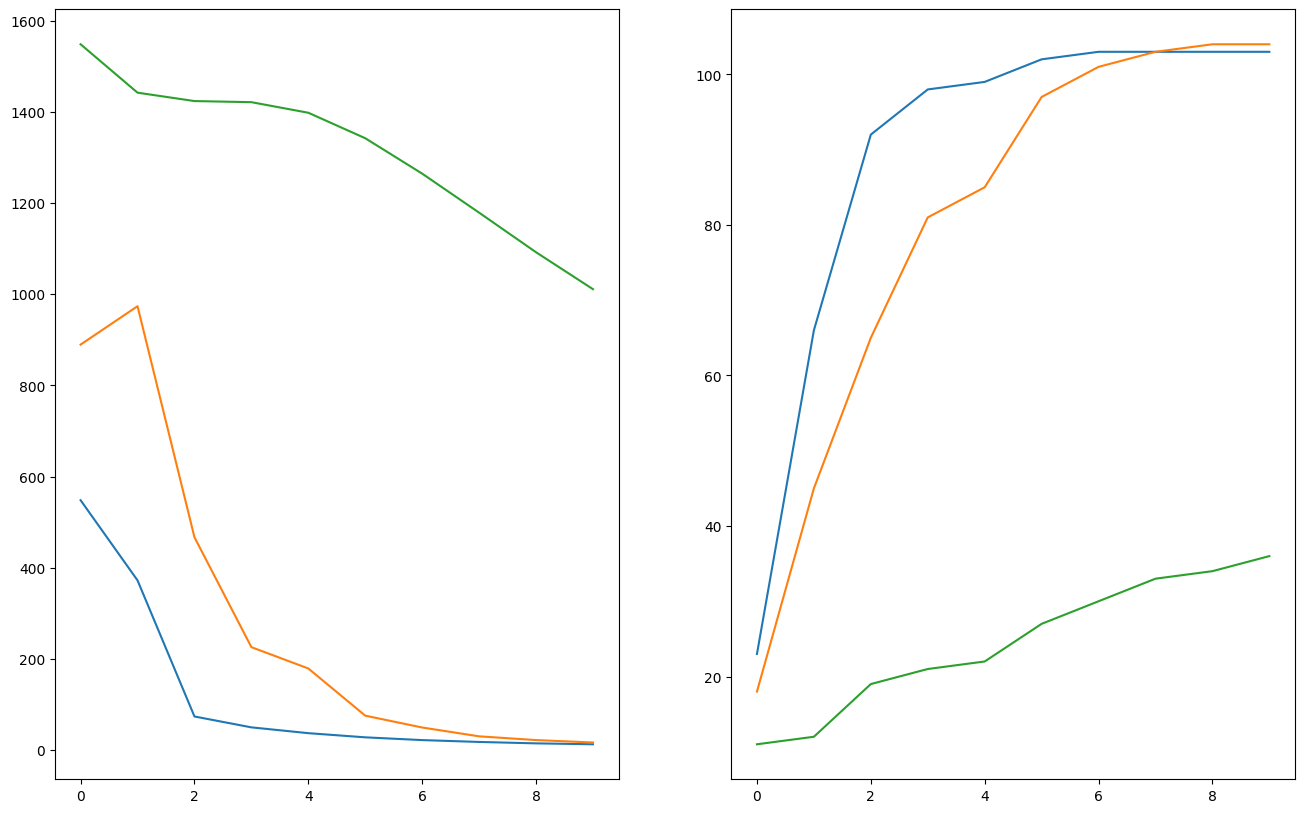

In [19]:
learning_rate_list = [0.01, 0.001, 0.0001]

loss_val = []
count_val = []
plt.figure(figsize=(16, 10))  # 전체 Figure 크기 설정
for i in range(len(learning_rate_list)):
    learning_rate = learning_rate_list[i]
    epochs = 50
    print(f'현재 learning_rate {learning_rate}')
    model = LinearModel(input_size=input_size, hidden_size1=hidden_size_1, hidden_size2=hidden_size_2, output_size=output_size, sample_num=sample_num, batch_size=batch_size, learning_rate=learning_rate, epochs=epochs)
    loss_val, count_val = model.forward(train_image, label)

    plt.subplot(1, 2, 1)
    plt.plot(loss_val, label="loss")
    plt.subplot(1, 2, 2)
    plt.plot(count_val, label="True count")
    test_result = model.test(test_data=test_image, test_label=test_label)
    calAccuracy(result=transposeMatrix(test_result), label=test_label)
    print('=========================================')

 - 결과 분석
 
 3가지의 학습률로 바꿔가며 epochs 50에서의 모델 성능을 측정했다. 위의 그래프를 참고했을때, 파란색으로 그어진 선(learning_rate = 0.01)이 가장 낮은 loss와 최고 정답률에 빠르게 수렴하는 모습을 보였고, 그 다음인 주황색 선(learning_rate = 0.001)도 뒤늦게 준수한 수준까지 따라와 주었다.
 하지만 초록색 선(learning_rate = 0.0001)은 학습률이 너무 낮았는지, loss가 충분히 낮아지지도 않았고, 정답률도 높아지는 속도가 느렸다. 너무 작은 학습률이라 가중치 파라미터의 업데이트 변동폭이 지나치게 작아서 이런 현상이 발생한 것으로 보인다.

현재 learning_rate 0.01
모델 생성 시작. 입력차원 256개, 1히든차원 96개, 2히든차원 48개, 출력층 7개로, 샘플 개수는 105개 입니다.
epochs : 1
training loss : 2189.109085886815
정답 개수 : 13
epochs : 2
epochs : 3
epochs : 4
epochs : 5
epochs : 6
training loss : 222.99846098280017
정답 개수 : 31
epochs : 7
epochs : 8
epochs : 9
epochs : 10
정답 개수 : 7
현재 learning_rate 0.01
모델 생성 시작. 입력차원 256개, 1히든차원 96개, 2히든차원 48개, 출력층 7개로, 샘플 개수는 105개 입니다.
epochs : 1
training loss : 1179.8787689268997
정답 개수 : 14
epochs : 2
epochs : 3
epochs : 4
epochs : 5
epochs : 6
training loss : 72.73715231123371
정답 개수 : 73
epochs : 7
epochs : 8
epochs : 9
epochs : 10
epochs : 11
training loss : 58.52866477120325
정답 개수 : 90
epochs : 12
epochs : 13
epochs : 14
epochs : 15
epochs : 16
training loss : 30.157613228934252
정답 개수 : 99
epochs : 17
epochs : 18
epochs : 19
epochs : 20
epochs : 21
training loss : 19.065005449059523
정답 개수 : 102
epochs : 22
epochs : 23
epochs : 24
epochs : 25
epochs : 26
training loss : 13.080919214119055
정답 개수 : 104
epochs : 27
epochs : 28
epo

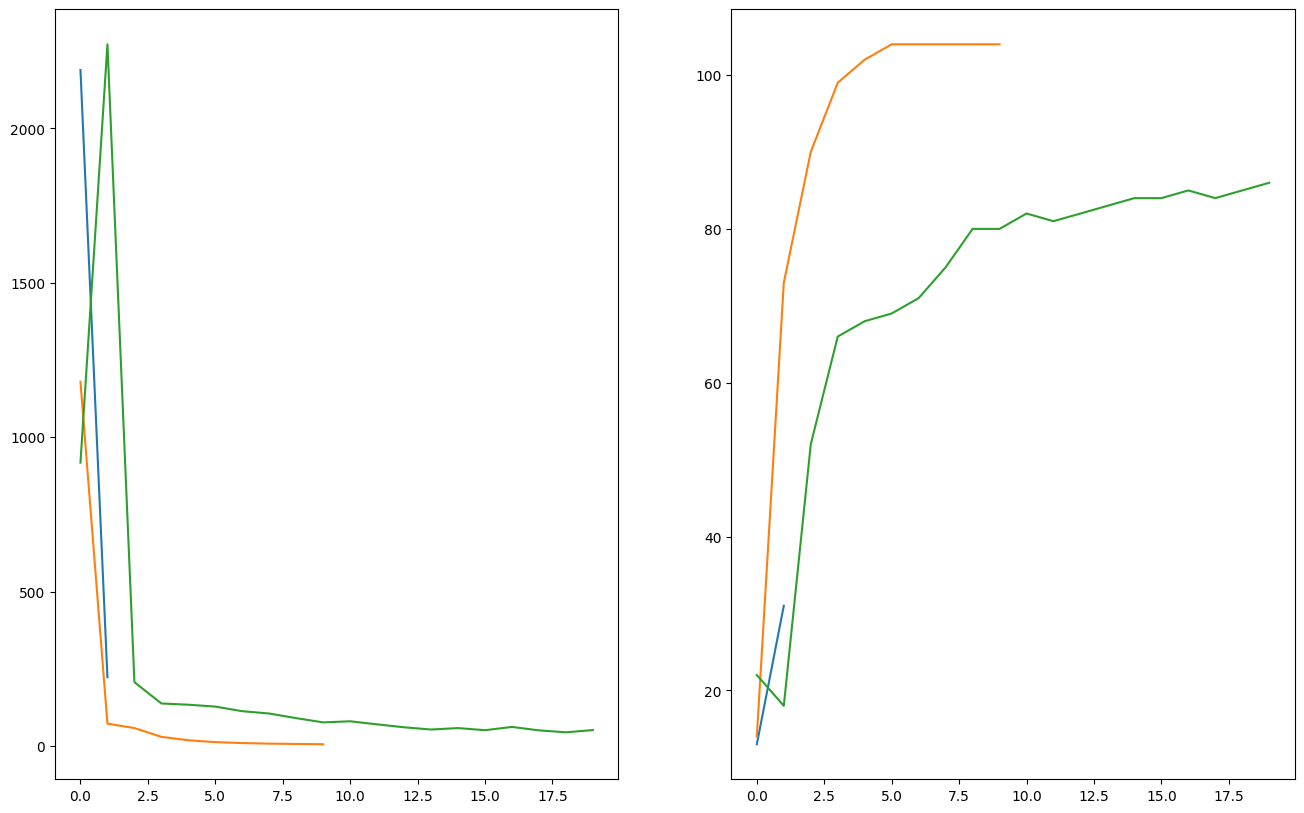

In [21]:
epochs_list = [10, 50, 100]

loss_val = []
count_val = []
plt.figure(figsize=(16, 10))  # 전체 Figure 크기 설정
for i in range(len(epochs_list)):
    learning_rate = 0.01
    epochs = epochs_list[i]
    print(f'현재 learning_rate {learning_rate}')
    model = LinearModel(input_size=input_size, hidden_size1=hidden_size_1, hidden_size2=hidden_size_2, output_size=output_size, sample_num=sample_num, batch_size=batch_size, learning_rate=learning_rate, epochs=epochs)
    loss_val, count_val = model.forward(train_image, label)

    plt.subplot(1, 2, 1)
    plt.plot(loss_val, label="loss")
    plt.subplot(1, 2, 2)
    plt.plot(count_val, label="True count")
    test_result = model.test(test_data=test_image, test_label=test_label)
    calAccuracy(result=transposeMatrix(test_result), label=test_label)
    print('=========================================')

- 결과 분석
epochs가 10밖에 안되는 파란선은 학습이 완전히 될 시간이 부족해 보인다. 이외에 epochs 50(주황색) epohcs 100(녹색)을 비교해보면 loss의 경우 학습이 일정부분 진행되도 loss가 계속 줄어들지 않고 일정 값에 수렴하는 경향이 있어 보인다. 정답률도 마찬가지로, 반복횟수가 적은 주황색 선이 운이 좋게 높은 정답률에 도달했지만 이후 일정 정답률을 유지하는것을 생각할때, 무조건 학습률을 높게 설정한다고해서 학습에 좋을 영향을 끼친다고 판단할수 없을것 같다.

오히려 적은 데이터셋을 과하게 학습시켜 오버피팅이 일어날수 있으므로, 위의 경우처럼 epochs 50으로도 충분한 성능을 이끌어 낼수 있을것으로 보인다.

현재 learning_rate 0.01
모델 생성 시작. 입력차원 256개, 1히든차원 96개, 2히든차원 48개, 출력층 7개로, 샘플 개수는 105개 입니다.
epochs : 1
training loss : 1892.3475529034329
정답 개수 : 12
epochs : 2
epochs : 3
epochs : 4
epochs : 5
epochs : 6
training loss : 2395.101655803431
정답 개수 : 19
epochs : 7
epochs : 8
epochs : 9
epochs : 10
epochs : 11
training loss : 140.93995577103433
정답 개수 : 22
epochs : 12
epochs : 13
epochs : 14
epochs : 15
epochs : 16
training loss : 109.39700405299281
정답 개수 : 21
epochs : 17
epochs : 18
epochs : 19
epochs : 20
epochs : 21
training loss : 407.353148751049
정답 개수 : 18
epochs : 22
epochs : 23
epochs : 24
epochs : 25
epochs : 26
training loss : 225.718966577828
정답 개수 : 36
epochs : 27
epochs : 28
epochs : 29
epochs : 30
epochs : 31
training loss : 167.83153452213458
정답 개수 : 21
epochs : 32
epochs : 33
epochs : 34
epochs : 35
epochs : 36
training loss : 355.94772610127006
정답 개수 : 37
epochs : 37
epochs : 38
epochs : 39
epochs : 40
epochs : 41
training loss : 113.75042541578445
정답 개수 : 45
epochs : 42
epoch

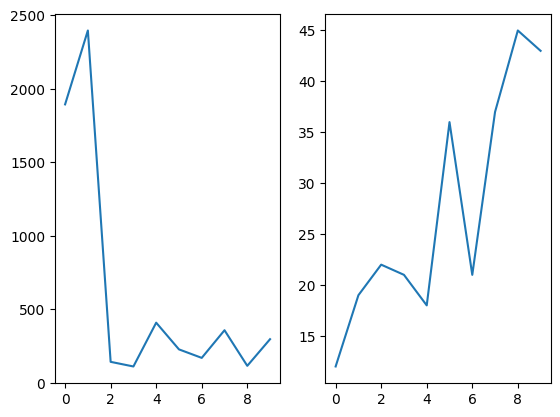

In [23]:

learning_rate = 0.01
epochs = 50
batch_size = 21
print(f'현재 learning_rate {learning_rate}')
model = LinearModel(input_size=input_size, hidden_size1=hidden_size_1, hidden_size2=hidden_size_2, output_size=output_size, sample_num=sample_num, batch_size=batch_size, learning_rate=learning_rate, epochs=epochs)
loss_val, count_val = model.forward(train_image, label)

plt.subplot(1, 2, 1)
plt.plot(loss_val, label="loss")
plt.subplot(1, 2, 2)
plt.plot(count_val, label="True count")
test_result = model.test(test_data=test_image, test_label=test_label)
calAccuracy(result=transposeMatrix(test_result), label=test_label)
print('=========================================')